**机器学习实战 书籍第二章例子学习笔记**
**获取数据(数据下载 测试集获取)**
书中源码here
本文地址here
> **注：**
> 1.增加CustomLabelBinarizer转换器解决参数传递问题（出现args参数数量错误）
> 2.在评估数据集some_data报错 因为选取数据object那个对象进行稀疏向量表示时会出现长度不是样本的5维，例如选择了5组数据，原本第一组属性是object应该是[1,0,0,0,0]表示一个值，但是因为选取5组数据使用one-hot编码后样本种类不足5导致第一组属性是object表示是[1,0,0] 那么长度就不一致了，预测会报错。

In [7]:
import os
import tarfile
from six.moves import urllib

*six.moves* 兼容py2 py3 
当然如果确认环境 也可以使用
import urllib.request
urllib.request.urlopen("http://")

In [8]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [9]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    print("download from url : ", housing_url)
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
fetch_housing_data()

download from url :  https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz


In [10]:
import pandas as pd
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
data = load_housing_data()

**pandas 查看原始数据常用**
- info() 数据简单描述
- describe() 数值属性摘要 count max min mean std(标准差 数据离散程度)这里的空值会被忽略
- value_counts() 查看数据基本分类

In [11]:
data.ocean_proximity.value_counts()
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


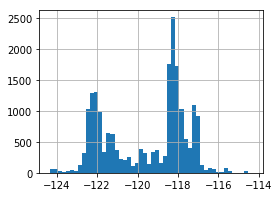

In [12]:
%matplotlib inline 
import matplotlib.pyplot as plt
data.longitude.hist(bins = 50, figsize = (4, 3))
plt.show()

**创建测试集**
测试集创建一次之后避免变化，四种方法：
1.运行一次之后保存测试数据集
2.设定随机种子，例如permutation产生随机数之前运行 np.random.seed(1)使得每次产生的随机数和首次一致（程序重新运行就失效了）
*sklearn提供了类似第二种方法函数:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)*
3.计算示例的hash  去hash最后一个字节 如果该值小于等于51 即（256的20%）当作测试集
4.**数据分层取样** 对于数据特征较少，且数据与某属性关联较大
*例如书籍上分析预测房价问题，房价和用户收入关联很大。例如用户收入聚集在2~5万，2万10人 3万20人，4万30人，5万30万，大于5万10人。那么收入比例分别是0.1， 0.2， 0.3， 0.3， 0.1，那么纯随机采样可能会出现和样本很大偏差。所以采用分层取样就可以得到和总样本基本一致的分布
sklearn 提供了分层取样方法
*


In [13]:
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_test(data, test_ratio=0.2)
print("train len : ", len(train_set), "  test len : ", len(test_set))

train len :  16512   test len :  4128


In [14]:
import hashlib 
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

#使用index作为索引
housing_with_id = data.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
# 或者可以使用地区经纬度进行计算
housing_with_id["id"] = data["longitude"] * 1000 + data["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

例如输入值为1 则hash(np.int64(identifier)).digest() 得到 *3\xcd\xec\xcc\xce\xbe\x802\x9f\x1f\xdb\xee\x7fXt\xcb*
取最后一个即0xcb 即203 203<(256\*0.2) 所以不是测试机

In [15]:
from sklearn.model_selection import train_test_split
#random_state 保存随机状态
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
print(train_set.shape,test_set.shape)

#分层取样 
#数据预处理 较少分层数量 /1.5 where满足条件时保留原始值，不满足条件时赋值5.0
data["income_cat"] = np.ceil(data["median_income"] / 1.5)
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace = True)
from sklearn.model_selection import StratifiedShuffleSplit
#n_splits是将训练数据分成train/test对的组数  此处只需要一组故为1 如果是多组可以发现样本分布概率基本一致
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
print("origin data percentage : " , data["income_cat"].value_counts()/ len(data))
print("test sample data percentage : " , strat_test_set["income_cat"].value_counts()/ len(strat_test_set))

#分组好之后删除income_cat数据
for item in (strat_train_set, strat_test_set):
    item.drop("income_cat", axis = 1, inplace=True)

(16512, 10) (4128, 10)
origin data percentage :  3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64
test sample data percentage :  3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


#### 从数据探索和可视化中获得洞见
##### 地理数据可视化

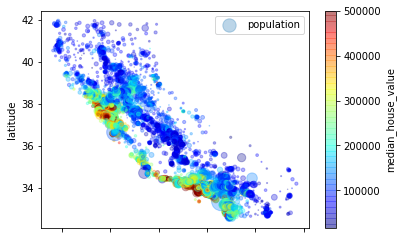

In [16]:
# 简单绘制经纬度
# data.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)
# s大小代表人口数量多少 c颜色按照右侧越大越靠近顶部颜色  cmap指定颜色分布向量
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3, s=data.population/100, 
         label="population", c="median_house_value", cmap=plt.cm.jet, colorbar=True)
plt.legend()

##### 寻找相关性
1.数据集不大情况下 可使用corr 公式如下
2.还可以使用pandas scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a4f5268d0>,
      dtype=object)

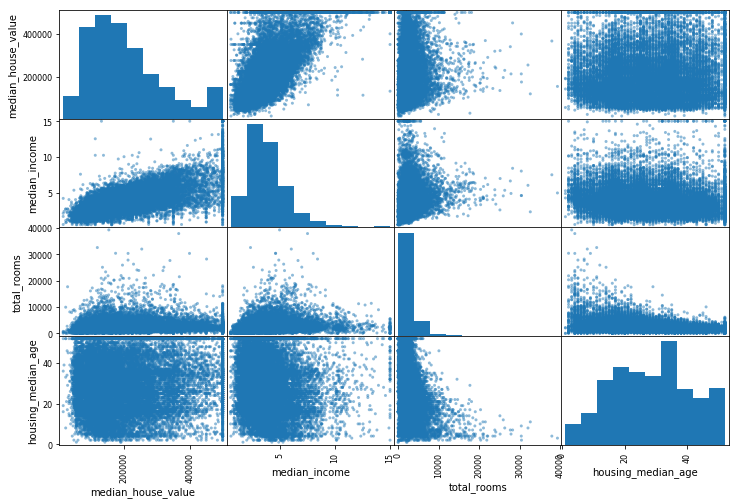

In [17]:
corr_matrix = data.corr()
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(data[attributes], figsize=(12, 8))

#### 数据预处理
##### 提取labels
##### 数据清理
1.丢失缺失的区域
2.放弃这个属性
3.填充缺失值
4.pandas Imputer

In [64]:
data = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()
# data.dropna(subset=["total_bedrooms"])
# data.drop("total_bedrooms", axis = 1)
median = data["total_bedrooms"].median()
data.total_bedrooms = data.total_bedrooms.fillna(median)
data.loc[data["total_bedrooms"].isnull()]#查看是否有空数据

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [68]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
# 因为中位数只能在数值属性操作 ocean_proximity是object类型 
housing_num = data.drop("ocean_proximity", axis = 1)
imputer.fit(housing_num)

#X是一个numpy array格式
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

##### 处理文本和分类属性
- LabelEncoder转成数字 OneHotEncoder转成向量
- LabelBinarizer直接转换成稀疏矩阵

In [40]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = data["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto')
# reshape 转成n*1维向量 输出是Numpy array
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

##### 自定义转换器
定义自己的转换器
- fit 
- transform 
- fit_transform 相当于fit 和 transform


In [108]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """主要是实现新增两列并通过参数add_bedrooms_per_room判断是否增加第三列"""
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]#每个家庭拥有的房间数
        population_per_household = X[:, population_ix] / X[:, household_ix]#平均人口数
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            #np.r_是按列连接两个矩阵，就是把两矩阵上下相加，要求列数相等。
            #np.c_是按行连接两个矩阵，就是把两矩阵左右相加，要求行数相等。
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(data.values)   
print(housing_extra_attribs.shape, data.shape)

(16512, 11) (16512, 9)


##### 特征缩放
- 最大-最小缩放（归一化， 减去最小值并除以最大值和最小值差值，容易受到极值影响，如果最大值或最小值是错误数据）
- 标准化 （减去平均值并除以方差）
##### 转换流水线
- pipeline
按照转换器顺序 将上一个输出作为下一个的输入
有了数值处理的流水线
\+单个流水线（那个object类型的字段）
- FeatureUnion

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
#中位数值 添加列 标准化
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])   
housing_num_str = num_pipeline.fit_transform(housing_num)

**添加DataFrameSeletor转换器 用于筛选字段**

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin) :
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [112]:
from sklearn.pipeline import FeatureUnion
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse_output=False):
        self.sparse_output = sparse_output
    def fit(self, X, y=None):
        self.enc = LabelBinarizer(sparse_output=self.sparse_output)
        self.enc.fit(X)
        return self
    def transform(self, X, y=None):
        return self.enc.transform(X)

#处理除object属性外的其他字段 DataFrameSeletor选择待处理字段
num_pipeline =  Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])   

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', CustomLabelBinarizer())
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])
housing_prepared = full_pipeline.fit_transform(data)

##### 选择和训练模型
训练和评估数据集

In [113]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
print(housing_prepared.shape, data.shape,data.columns)

(16512, 16) (16512, 9) Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')


In [154]:
some_data = data.iloc[0:7000]
some_labels = housing_labels.iloc[0:7000]
some_data_prepared = full_pipeline.fit_transform(some_data)

#使sklearn mean_squere_error来测量均方误差
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

**引入决策树模型**
当然在验证模型准确率可以使用之前分离好的测试集，但对于模型训练过程来说使用验证集基本没问题情况下再进行测试

In [164]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

**使用交叉验证进行评估**

In [158]:
from sklearn.model_selection import cross_val_score
#cv=10 表示训练集分割成10个不同的子集 每次取出9个fold进行训练 1个进行评估
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)

In [165]:
def display_scores(scores):
    print("Scores : ", scores)
    print("Means : ", scores.mean())
    print("Standard deviation : ", scores.std())
display_scores(rmse_scores)

Scores :  [70899.33464216 66874.12816236 70810.08125047 68433.27517707
 71252.06186727 76145.80404286 71353.01041903 69879.20238633
 76328.64886368 69509.95086644]
Means :  71148.54976776752
Standard deviation :  2863.124346932114


In [167]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
# forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv = 10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores :  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Means :  69052.46136345083
Standard deviation :  2731.674001798346


/root/anaconda3/envs/kerasGPU/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/root/anaconda3/envs/kerasGPU/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/root/anaconda3/envs/kerasGPU/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/root/anaconda3/envs/kerasGPU/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/root/anaconda3/

Scores :  [53487.699654   49876.09500831 53287.92305579 53956.57103732
 52268.69590147 56505.14081467 51049.97569407 50315.90898493
 53984.36616521 53434.31185671]
Means :  52816.668817248734
Standard deviation :  1887.9570620550105


**保存模型**

In [168]:
from sklearn.externals import joblib
joblib.dump(forest_reg, "my_forest_model.pkl")
my_forest_model = joblib.load("my_forest_model.pkl")

##### 微调模型
- 手动改参数 但是比较繁琐
- 使用sklearn GridSearch将预设参数设置好，并进行找出最佳组合
**n_estimators**：表示森林里树的个数。理论上是越大越好。但是伴随着就是计算时间的增长。但是并不是取得越大就会越好，预测效果最好的将会出现在合理的树个数。
**max_features**：随机选择特征集合的子集合，并用来分割节点。子集合的个数越少，方差就会减少的越快，但同时偏差就会增加的越快。
grid_search.best_params_ 最佳的参数组合
grid_search.best_estimator_ 最好估算器
grid_search.cv_results_评估分数
- 当组合参数数量较少时可以使用使用GridSearch 但当超参数在一个范围时，优先选择RandomizedSearchCV，该方法随机获取参数
- **集成方法** 通过对表现最优的模型组合起来

In [172]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap' : [False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]}
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf='deprecated', min_samples_split=2,
           min_weight_fraction_leaf='deprecated', n_estimators='warn',
           n_jobs=None, oob_score=False, random_state=None, verbose=0,
           warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [174]:
##### 分析最佳模型
- 获取属性重要性分数，通过对该分数分析得出哪些属性对模型影响较大
- 使用之前训练集分析模型

{'max_features': 6, 'n_estimators': 30}

In [177]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3538303474203912, 'median_income'),
 (0.1525483326015585, 'INLAND'),
 (0.101204378463717, 'pop_per_hhold'),
 (0.07872545634183621, 'longitude'),
 (0.06651751258549214, 'latitude'),
 (0.06553637571390171, 'bedrooms_per_room'),
 (0.051725771620178024, 'rooms_per_hhold'),
 (0.042688242675363294, 'housing_median_age'),
 (0.017340593201825353, 'total_rooms'),
 (0.017249513336270453, 'population'),
 (0.017036535830323087, 'total_bedrooms'),
 (0.01637009267511644, 'households'),
 (0.011241359129170606, '<1H OCEAN'),
 (0.0052492509103651335, 'NEAR OCEAN'),
 (0.002615778861548063, 'NEAR BAY'),
 (0.0001204586329427789, 'ISLAND')]

In [179]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

49748.726201228776